In [157]:
from bs4 import BeautifulSoup
import re
import pandas as pd
import requests
import multiprocess as mp
from selenium import webdriver
import json
import time
import spacy
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
def get_html(url):
    response = requests.get(url, verify= True)
    return response.text

In [54]:
top100_url = 'https://www.theguardian.com/books/2015/aug/17/the-100-best-novels-written-in-english-the-full-list'

In [55]:
#Make soups from the html
dom = BeautifulSoup(get_html(top100_url),'html.parser')
book_soup = dom.find_all('a', attrs={"data-link-name": "in body link"})
author_soup = dom.find_all('strong')


In [57]:
#Get book titles and authors

#Create a list of book titles
book_titles_unclean = [item.text for item in book_soup]

#Manually delete some unwanted items and optimize the title for putting into the url
delete = ['Thomas Love Peacock','Shelley','arrived this summer']
book_titles_clean = [item.replace(' ','+') for item in book_titles_unclean if item not in delete]

#Create a list of authors and manually skip the first one
authors_unclean = [item.text for item in author_soup][1:]
authors_clean = []
#The text has a format '1. ABCDE by Chris Pat (XXXX)', therefore use regular expression
for i in authors_unclean:
    #Search mattern consisting one capture group
    match = re.search(r"by\s+(.*?)\s+\(",i)
    if match:
        #Append the matches to the list of authors
        authors_clean.append(match.group(1))

In [176]:
#There are 100 titles and authors
print(len(book_titles_clean))
print(len(authors_clean))

100
100


In [60]:
#To connect details about the book, like its search_page url, goodreads summary etc, 
#I will make a nested dictionary with the book title as the primary key.
nested_dict = {}

#Fill the dictionary with book name and the author information, as well as the search page url.
for title, name in zip(book_titles_clean,authors_clean):
    
    #The search_url leads us to a page of search results of the book title in goodreads
    nested_dict[title] = {'author':name, 'search_url' : 'https://www.goodreads.com/search?utf8=%E2%9C%93&q='+str(title)+'&search_type=books',}


In [ ]:
#Checking if the dict is correct
print(nested_dict)
for key, value in nested_dict.items():
    print(key,value)

In [95]:
#Since for some reason I cannot get the goodreads html properly with requests, I tried using Selenium instead
def sel_get_html(url):

    #Select firefox as driver
    driver = webdriver.Firefox()

    #Get the html
    driver.get(url)
    soup = driver.page_source
    
    #time.sleep(3) <- This was added because for a period it seemed like goodreads blocked my ip for accessing too many times
    driver.close()
    return soup

In [63]:
#Use multiproccessing to get the url's html

#Retrieve a list of urls from the dictionary
search_url_list = []
for bookdict in nested_dict.values():
    search_url_list.append(bookdict['search_url'])
print(search_url_list)

#Multiprocess returns a list of html
if __name__ == '__main__':
    with mp.Pool(processes = 10) as pool:
        search_html_list = pool.map(sel_get_html,search_url_list)

['https://www.goodreads.com/search?utf8=%E2%9C%93&q=The+Pilgrim’s+Progress&search_type=books', 'https://www.goodreads.com/search?utf8=%E2%9C%93&q=Robinson+Crusoe&search_type=books', 'https://www.goodreads.com/search?utf8=%E2%9C%93&q=Gulliver’s+Travels&search_type=books', 'https://www.goodreads.com/search?utf8=%E2%9C%93&q=Clarissa&search_type=books', 'https://www.goodreads.com/search?utf8=%E2%9C%93&q=Tom+Jones&search_type=books', 'https://www.goodreads.com/search?utf8=%E2%9C%93&q=The+Life+and+Opinions+of+Tristram+Shandy,+Gentleman&search_type=books', 'https://www.goodreads.com/search?utf8=%E2%9C%93&q=Emma&search_type=books', 'https://www.goodreads.com/search?utf8=%E2%9C%93&q=Frankenstein&search_type=books', 'https://www.goodreads.com/search?utf8=%E2%9C%93&q=Nightmare+Abbey&search_type=books', 'https://www.goodreads.com/search?utf8=%E2%9C%93&q=The+Narrative+of+Arthur+Gordon+Pym+of+Nantucket&search_type=books', 'https://www.goodreads.com/search?utf8=%E2%9C%93&q=Sybil&search_type=books', '

In [64]:
#Add the search page html content to the nested dictionary
for book, html in zip(nested_dict.copy().keys(),search_html_list):
    nested_dict[book]['search_html'] = html

In [65]:
#Save the nested dictionary as a json file as backup
with open('output.json','w') as file:
    json.dump(nested_dict,file)

In [66]:
#Retreive the nested dictionary from the json file
with open('output.json', 'r') as file:
    nested_dict = json.load(file)

In [83]:
#Now we scrape the search page htmls for the book's goodreads url

#The idea is to run a for loop and scrape the html one at a time
for book, bookdict in nested_dict.copy().items():

    #Make soup
    dom = BeautifulSoup(bookdict['search_html'])

    #Retrieve the all the book titles (containing the href) and the corresponding author of the search result and verify later
    book_url_soup = dom.find_all('a',class_='bookTitle')
    author_soup = dom.find_all('a',class_='authorName')
    print('finding right url for:',book)

    #Now we loop through each search result to see which result is the correct one
    for i,j in zip(book_url_soup, author_soup):
        
        #The result is accpeted if the author's name correspond to our data. 
        #The flaw is that there are inconsistencies e.g. missing middlenames, dots between initials requiring manual handling.
        if j.text in nested_dict[book]['author']or nested_dict[book]['author'] in j.text:
            print('Accepted: ',book,j.text)
            print('-------------------------------')
            nested_dict[book]['goodreads_url'] = i['href']
            break

        #If none of the result matces our data in the nested dictionary, I will handle it myself.
        elif i == book_url_soup[-1]:
            print('Alert: default',book_url_soup[0].text,author_soup[0].text)
            nested_dict[book]['goodreads_url'] = book_url_soup[0]['href']
        
        #If the result does not match, move on to the next one
        else:
            print('Not a match: ',j.text,i.text)
            print('-------------------------------')
            
            
#As it turns out, Frankenstein, The Rainbow, Nineteen Nineteen, Murphy, Joy in the Morning require manual input.


finding right url for: The+Pilgrim’s+Progress
-------------------------------
finding right url for: Robinson+Crusoe
-------------------------------
finding right url for: Gulliver’s+Travels
-------------------------------
finding right url for: Clarissa
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
finding right url for: Tom+Jones
-------------------------------
finding right url for: The+Life+and+Opinions+of+Tristram+Shandy,+Gentleman
-------------------------------
finding right url for: Emma
-------------------------------
finding right url for: Frankenstein
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
-------------------------------
Alert: default 
Cleopatra and

In [84]:
#Frankenstein, The Rainbow, Nineteen Nineteen, Murphy, Joy in the Morning require manual input
nested_dict['Frankenstein']['goodreads_url'] = '/book/show/35031085-frankenstein?from_search=true&from_srp=true&qid=HBPM4oemc5&rank=1'
nested_dict['The+Rainbow']['goodreads_url'] = '/book/show/31491.The_Rainbow?from_search=true&from_srp=true&qid=dIefDSsN75&rank=6'
nested_dict['Nineteen+Nineteen']['goodreads_url'] = '/book/show/7104.1919?from_search=true&from_srp=true&qid=72DizgkXU8&rank=9'
nested_dict['Murphy']['goodreads_url'] = '/book/show/142702855-murphy-by-samuel-beckett?ac=1&from_search=true&qid=GcgDWh3TI5&rank=1'
nested_dict['Joy+in+the+Morning']['goodreads_url'] = '/book/show/9928818-joy-in-the-morning?from_search=true&from_srp=true&qid=r9HfHkLCOa&rank=2'

In [100]:
#Now that we have all the book's url on goodreads, we can scrape them.

#Create a list of url consisting of goodreads url. 
goodreads_url_list = []

#Loop through the second-level dictionary of each title to add the domain name to the url
for bookdict in nested_dict.values():
    goodreads_url_list.append('https://www.goodreads.com'+bookdict['goodreads_url'])

#Do the actual scraping with multiprocess and selenium
if __name__ == '__main__':
    with mp.Pool(processes = 5) as pool:
        goodreads_html_list = pool.map(sel_get_html,goodreads_url_list)

In [101]:
#Append the scraped htmls into the dictionary
for book, html in zip(nested_dict.copy().keys(),goodreads_html_list):
    nested_dict[book]['goodreads_html'] = html

In [102]:
#Save progress
with open('output.json','w') as file:
    json.dump(nested_dict,file)

In [ ]:
#Now we scrape the summary and rating from the goodreads page with a for loop. The idea is similar as before (should have defined a function here).

for book, bookdict in nested_dict.copy().items():

    #Make soup
    dom = BeautifulSoup(bookdict['goodreads_html'])

    #Check whether the book title on the html corresponds to our record
    title_soup = dom.find('h1',class_="Text Text__title1")
    print(title_soup,book)

    #Scrape the rating and summary
    rating_soup = dom.find('div',attrs={'class':'RatingStatistics__rating'})
    summary_soup = dom.find('div',class_='DetailsLayoutRightParagraph__widthConstrained')

    #Append the rating and summary to our dictionary
    nested_dict[book]['rating'] = rating_soup.text.strip()
    nested_dict[book]['summary'] = summary_soup.text.strip()



In [104]:
#Save progress
with open('output.json','w') as file:
    json.dump(nested_dict,file)

In [127]:
#Now we use spacy to do the text mining. 
nlp = spacy.load("en_core_web_sm")

#Here I define a function where I can tokenize the summaries of the books, and also calculate the tf since it's convenient
#The idea is to create a nested dictionary with the book title as the primary key, the tokens as the secondary key, and tf, idf, tf-idf as the tertiary keys.
def turn_into_filtered_tokens(nested_dict):

    #Instantiate the dictionary
    doc_dict ={}

    #Loop through the original nested dict to retrieve book title and corresponding summary 
    for title, bookdict in nested_dict.items():

        #Create a doc out of the summary
        doc = nlp(nested_dict[title]['summary'])

        #Tokenize the summary, while removing stopwords, only including nouns, and returning the lemma of the word in the process
        filtered = [token.lemma_ for token in doc if not token.is_stop and token.pos_ == "NOUN"]

        #Instantiate the secondary dictionary
        doc_dict[title] = {}

        #Append the tokens and its tf value in the dictionary
        for token in filtered:
            doc_dict[title][token] = {'tf':math.log(1+filtered.count(token)/len(filtered))}

    return doc_dict

In [ ]:
#Run the defined function
doc_dict = turn_into_filtered_tokens(nested_dict)

In [141]:
#Now we try to calculate the idf of each token
#The idea is to loop through each title in the dictionary. Then I will loop through each token under the title. 
#In this second loop, I will loop through all titles and their respective tokens to check if the token appears in other docs. 
def cal_idf(doc_dict):

    #Create the first big loop
    for title in doc_dict.copy().keys():

        #Second loop for the token
        for token in doc_dict[title].copy().keys():
            token_count = 0

            #Loop through the keys of the dictionaries from all the books
            for title2 in doc_dict.copy().keys():

                #If the token appears in the keys of a particular token dictionary of a book, then token count increases by one
                if token in doc_dict[title2].copy().keys():
                    token_count += 1
            
            #With this token_count we can calculate the idf and tf-idf, then append it in the dictionary
            doc_dict[title][token]['idf'] = math.log(len(doc_dict)/token_count)
            doc_dict[title][token]['tf-idf'] = doc_dict[title][token]['tf']*doc_dict[title][token]['idf']
    return doc_dict
cal_idf(doc_dict)

{'The+Pilgrim’s+Progress': {'story': {'tf': 0.03278982282299097,
   'idf': 1.171182981502945,
   'tf-idf': 0.03840288245678388},
  'man': {'tf': 0.03278982282299097,
   'idf': 1.2378743560016172,
   'tf-idf': 0.04058968081041708},
  'progress': {'tf': 0.03278982282299097,
   'idf': 3.912023005428146,
   'tf-idf': 0.12827454122745355},
  'life': {'tf': 0.03278982282299097,
   'idf': 0.843970070294529,
   'tf-idf': 0.02767362907286484},
  'search': {'tf': 0.03278982282299097,
   'idf': 3.2188758248682006,
   'tf-idf': 0.1055463679866372},
  'salvation': {'tf': 0.03278982282299097,
   'idf': 4.605170185988092,
   'tf-idf': 0.1510027144682699},
  'allegory': {'tf': 0.03278982282299097,
   'idf': 3.912023005428146,
   'tf-idf': 0.12827454122745355},
  'faith': {'tf': 0.03278982282299097,
   'idf': 3.506557897319982,
   'tf-idf': 0.11497941217168196},
  'backdrop': {'tf': 0.03278982282299097,
   'idf': 3.506557897319982,
   'tf-idf': 0.11497941217168196},
  'town': {'tf': 0.03278982282299097

In [153]:
#Now we want the top 15 tags for each book. 

#The idea is to go through the doc_dictionary we have used so far, turn it into a DataFrame and use nlargest to sort through the scores. 
#After that we append the tf-idf scores to the big nested dictionary.  
def return_15_tags(doc_dict,nested_dict):

    #Loop through doc_dict
    for title in doc_dict.copy().keys():

        #Create df from dictionary
        data = doc_dict[title]
        df = pd.DataFrame.from_dict(data, orient = 'index')
        df['words'] = df.index
        df.reset_index

        #Make a dictionary out of the top 15 results in the format {'token':tf-idf score}
        top_15_words_dict = dict(zip(df.nlargest(15,'tf-idf')['words'],df.nlargest(15,'tf-idf')['tf-idf']))

        #Append the result to the big nested dictionary
        nested_dict[title]['tags'] = top_15_words_dict

    return nested_dict
nested_dict = return_15_tags(doc_dict,nested_dict)

In [154]:

#Save progress
with open('output.json','w') as file:
    json.dump(nested_dict,file)

In [ ]:
#Now we try plot the top 15 tags for each book with seaborn barcharts by looping through the dictionary

for title in nested_dict.copy().keys():
    
    #Retrieve the tags dictionary
    tag_dict = nested_dict[title]['tags']
    
    #Turn it into a df so we can plot easily with seaborn
    df = pd.DataFrame(list(tag_dict.items()),columns=['tag','tf-idf'])
    df['tag'] = df['tag'].str.replace('+',' ')
    
    #Clear plot
    plt.clf()
    plt.figure(figsize=(10,10))

    #Plot barchart
    sns.barplot(x='tag',y='tf-idf',data=df)

    #Configure title and labels
    plt.title('Top 15 key words with the highest TF-IDF score for '+str(title))
    plt.xticks(rotation=90)

    #Save the figure to '/Plots'
    plt.savefig(os.path.join('./Plots',title+'.png'))

,tag,tf-idf,rating
0,language,0.193340,4.05
0,sailor,0.400702,3.68
0,voyage,0.104681,3.58
0,virtue,0.263224,3.39
0,introduction,0.084498,3.75
...,...,...,...
0,quarrel,0.173801,3.67
0,guerilla,0.368610,3.95
0,baseball,0.144677,3.94
0,communication,0.214233,3.85


<Figure size 640x480 with 0 Axes>

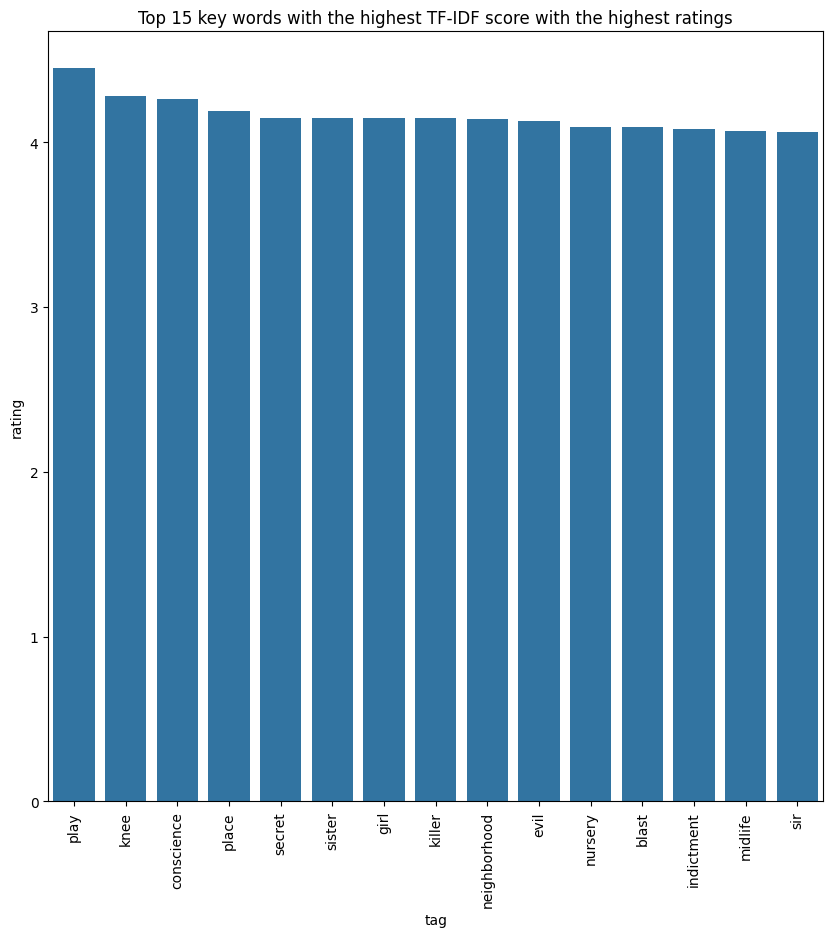

In [175]:
#The additional research question is: What are the tags with the highest ratings?
#Essentially, I pull the top tag for each book as well as the book's rating and plot the top 15 results. 

#Instantiate an empty dataframe to add onto it later
concat_df = pd.DataFrame()

#Loop through the books
for title in nested_dict.copy().keys():

    #Retrieve the tag dictionary
    tag_dict = nested_dict[title]['tags']

    #Make a df out of the top tag and its rating
    df = pd.DataFrame(list(tag_dict.items()),columns=['tag','tf-idf'])
    df_largest = df.nlargest(1,'tf-idf')
    df_largest['rating'] = nested_dict[title]['rating']

    #Add the row to the compiled df
    concat_df = pd.concat([concat_df,df_largest])
display(concat_df) 

#Check if the rating column have the right data type
concat_df['rating'] = pd.to_numeric(concat_df['rating'])

#Get the top_15 results from the compiled_df
top_15_df = concat_df.nlargest(15,'rating')

#Plot the graph and save it in /Plots
plt.clf()
plt.figure(figsize=(10,10))
sns.barplot(x='tag',y='rating',data=top_15_df)
plt.title('Top 15 key words with the highest TF-IDF score with the highest ratings')
plt.xticks(rotation=90)
plt.savefig(os.path.join('./Plots','Top15ratings.png'))
